In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [11]:
# 데이터 준비
transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])

In [5]:
# #데이터준비2
# train_dataset = datasets.ImageFolder(r"E:\Data\dogs_vs_cats\train", transform=transform)

# test_dataset = datasets.ImageFolder(r"E:\Data\dogs_vs_cats\test", transform=transform)

In [10]:
import os

db = r"E:\Data\dogs_vs_cats" 
train_files = []
test_files = []

for dir in ["dogs", "cats"]:
    train_files += [os.path.join(db, 'train', dir, f) for f in os.listdir(r"{}\train\{}".format(db, dir))]
    test_files += [os.path.join(db, 'test', dir, f) for f in os.listdir(r"{}\test\{}".format(db, dir))]

len(train_files), len(test_files)


(20000, 5000)

In [28]:
from torch.utils.data import Dataset
from PIL import Image

class DogVsCatsDataset(Dataset):
    def __init__(self, file_list, transform = None):
        self.file_list = file_list
        self.transfrom = transform

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        transformed_img = self.transfrom(img)

        label = None
        if 'cat' in img_path.split("\\")[-1].lower():
            label = 0
        else:
            label = 1
        return transformed_img, label


In [29]:
train_files[0]

'E:\\Data\\dogs_vs_cats\\train\\dogs\\dog.0.jpg'

In [30]:
train_dataset = DogVsCatsDataset(train_files, transform)
test_dataset = DogVsCatsDataset(train_files, transform)

In [31]:
##데이터준비3
train_loder = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=32,
                                          shuffle=True)

test_loder = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=True)

In [32]:
for x, y in train_loder:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


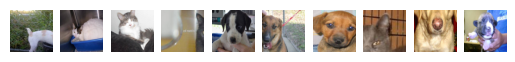

tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1])

In [33]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis("off")
    plt.imshow(x[idx, :, :, :].permute(1, 2, 0))
plt.show()
y[:10]

In [9]:
# 모델구조설계
class MnistCNN(nn.Module):
    def __init__(self): # 주로 층을 만듬
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear( 56 * 56 * 16, 32 )
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view( -1, 56 * 56 * 16 )
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim= 1)
        return x

In [10]:
#학습 도구 구성
model = MnistCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

MnistCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [11]:
# 훈련함수 만들기(학습설계)
def train(model, train_loder, optimizer):
    model.train() # train_mode로 설정
    for idx, (images, labels) in enumerate(train_loder):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 187 == 0:
            print(f"Batch : {idx}, Loss : {loss.item()}")

In [12]:
def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval() # 평가모드로 설정 -> batch_normalization, drop_out 수행 중지
    with torch.no_grad(): #가중치 업데이터 수행 중지
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim = True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total = loss_total / ( len(test_dataset) / 32 )
    # loss_total /= ( len(test_dataset) / 32 )

    accuracy = correct_total / len(test_dataset)

    return loss_total, accuracy

In [13]:
# def debug_test():
#     print("debug_test")
#     print("debug_test2")
#     print("debug_test3")

In [ ]:
# aprint("start debugging")
# debug_test()
# evaluate(model= model, test_loader= test_loder)

start debugging
debug_test
debug_test2
debug_test3


(2.28227001953125, 0.5)

In [15]:
for epoch in range(10):
    
    train(model=model, train_loder=train_loder, optimizer=optimizer)
    loss, acc = evaluate(model, test_loder)
    print(f"Epoch : {epoch+1}, Loss: {loss}, Accuracy: {acc}")
    

Batch : 0, Loss : 2.2343530654907227
Batch : 187, Loss : 0.7149332761764526
Batch : 374, Loss : 0.6977320313453674
Batch : 561, Loss : 0.6428502798080444
Epoch : 1, Loss: 0.6560040740966797, Accuracy: 0.603
Batch : 0, Loss : 0.6138717532157898
Batch : 187, Loss : 0.5836063623428345
Batch : 374, Loss : 0.6819107532501221
Batch : 561, Loss : 0.5843918323516846
Epoch : 2, Loss: 0.6348938306808471, Accuracy: 0.6326
Batch : 0, Loss : 0.592666745185852
Batch : 187, Loss : 0.6111048460006714
Batch : 374, Loss : 0.5325725078582764
Batch : 561, Loss : 0.6903054118156433
Epoch : 3, Loss: 0.5934852186203003, Accuracy: 0.6822
Batch : 0, Loss : 0.5675227046012878
Batch : 187, Loss : 0.5804144144058228
Batch : 374, Loss : 0.5993534922599792
Batch : 561, Loss : 0.5998849868774414
Epoch : 4, Loss: 0.6024820697784424, Accuracy: 0.6846
Batch : 0, Loss : 0.4798576533794403
Batch : 187, Loss : 0.5190234184265137
Batch : 374, Loss : 0.5106797218322754
Batch : 561, Loss : 0.6195880770683289
Epoch : 5, Loss:

In [16]:
evaluate(model = model, test_loader = test_loder)

(0.5552282052993774, 0.7094)